In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import tqdm
import sys
import os

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, auc, roc_curve
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [3]:

dataset = torchvision.datasets.ImageFolder(root="C:/Users/Wxei/fitoBack/White224Bin/")

split_ratio = 0.7

train_size = int(split_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [4]:
train_set.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
BATCH_SIZE = 512

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=6)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True,  num_workers=6)

cuda = torch.device('cuda')

In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 6, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(6, 12, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    
    nn.Flatten(),
    nn.Linear(6912, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Sigmoid()
).to(cuda)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

n_epochs = 20

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device="cuda:0"):
    model.train()
    train_losses = []
    for imgs, true_labels in train_loader:
        out = model(imgs.to(device)).squeeze()
        loss = criterion(out, true_labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    sns.lineplot(x=range(len(train_losses)), y=train_losses)
    plt.xlabel('train step')
    plt.ylabel('train loss')
    plt.show()

In [9]:
def run_test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for imgs, true_labels in test_loader:
            out = model(imgs.to(device)).squeeze()
        pred_labels = np.argmax(out.detach().cpu(), axis=1).tolist()
    return accuracy_score(true_labels.detach().cpu().numpy(), pred_labels)

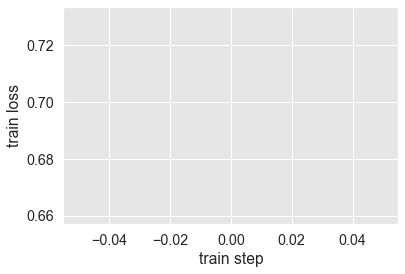

accuracy: 0.44


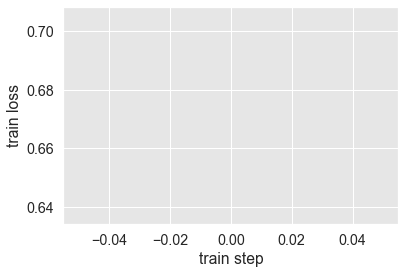

accuracy: 0.7333333333333333


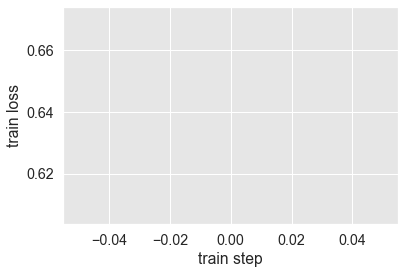

accuracy: 0.76


KeyboardInterrupt: 

In [10]:
for epoch in range(n_epochs):
    train_epoch(model, train_loader, criterion, optimizer, cuda)
    acc = run_test(model, test_loader, cuda)
    scheduler.step()
    print(f'accuracy: {acc}')

In [ ]:
def evaluation(model, test_loader, device):
    model.eval()
    for imgs, true_labels in test_loader:
        out = model(imgs.to(device)).squeeze()
        true_labels = true_labels.float().to(device)
    pred_labels = (out.detach().cpu().numpy() > 0.5).astype(int)
    true_labels = true_labels.detach().cpu().numpy()
    acc = accuracy_score(true_labels, pred_labels)
    pr = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    print(f'accuracy: {acc}')
    print(f'precision: {pr}')
    print(f'recall: {recall}')
    
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels, pos_label=1)
    auc_score = auc(fpr, tpr)
    print(f'auc: {auc_score}')
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    heatmap = sns.heatmap(conf_matrix, annot=True)
    heatmap.set(xlabel='Predicted label', ylabel='True label')
    plt.show()
    

accuracy: 0.976
precision: 0.9846153846153847
recall: 0.9696969696969697
auc: 0.9763739085772986


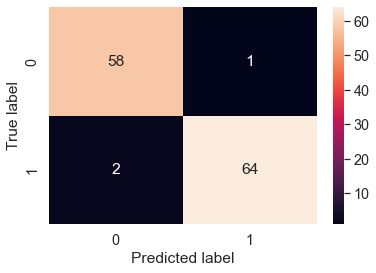

In [12]:
evaluation(model, test_loader, cuda)

# Save model

In [16]:
path = "C:/Users/Nexei/fito/savedModels/basic-0.pt"

In [17]:
torch.save(model, path)

In [16]:
def load_model(path):
    model = torch.load(path)
    model.eval()
    return model